In [1]:
import numpy as np
import xarray as xr
import glob
import os
from datetime import timedelta
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datadir='data/'
north = '600S' # 300S, 600S
#dset = '_southof%s_swmt_decomposed_'%north
#dset = '_southof%s_swmt_onvoffshelf_'%north
dset = '_southof%s_swmt_onvoffshelf_decomposed_'%north
lstr = 'sigma2'
dl = '002' # 005, 002

In [3]:
ddict = {mod:{} for mod in ['CM4','ESM4']}
for mod in ddict:
    ddict_exp = {exp:{} for exp in ['control','antwater','stress','antwaterstress']}
    for exp in ddict_exp:
        
        if exp == 'control':
            head = '%s_%s'%(mod,exp)
            
            files = glob.glob(datadir+head+'_so_*'+dset+'%s_%s.nc'%(lstr,dl))
            
            if len(files)>1:
                print('WARNING: More than one file for '+head)
            elif len(files)==0:
                print('ERROR: No file available for '+head)
                ddict[mod] = []
                continue
                
            print('Loading '+os.path.basename(files[0]))
            ddict_exp[exp] = xr.open_dataset(files[0])
                
        else:
            ddict_mem = {mem:{} for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201'])}
            for mem in ddict_mem:
                head = '%s_%s_%s'%(mod,exp,mem)   
                files = glob.glob(datadir+head+'_so_*'+dset+'%s_%s.nc'%(lstr,dl))
                
                if len(files)>1:
                    print('WARNING: More than one file for '+head)
                elif len(files)==0:
                    print('ERROR: No file available for '+head)
                    ddict_mem[mem] = []
                    continue
                    
                print('Loading '+os.path.basename(files[0]))
                ddict_mem[mem] = xr.open_dataset(files[0])
            ddict_exp[exp] = ddict_mem
    ddict[mod] = ddict_exp

Loading CM4_control_so_0251to0395_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwater_251_so_0001to0100_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwater_290_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwater_332_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_stress_251_so_0001to0100_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_stress_290_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_stress_332_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwaterstress_251_so_0001to0100_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwaterstress_290_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading CM4_antwaterstress_332_so_0001to0070_southof600S_swmt_onvoffshelf_decomposed_sigma2_002.nc
Loading ESM4_control_so_0101to0270_southof600S_swmt_onvoffshelf

In [4]:
tsdict = {mod:{} for mod in list(ddict.keys())}
for mod in tsdict:
    tsdict[mod] = {exp:{} for exp in list(ddict[mod].keys())}
    
for mod in tsdict:
    for exp in tsdict[mod]:
        if exp=='control':
            tsdict[mod][exp] = ddict[mod][exp]*1e-6
        else:
            Gs = []
            for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
                
                G = ddict[mod][exp][mem]*1e-6
                if mem == '101':
                    G['time'] = G.time - timedelta(days=365*(int(mem)-1))
    
                G['mem'] = int(mem)
                Gs.append(G)
                
            tsdict[mod][exp] = xr.concat(Gs, dim='mem')

### Load maximum MLD from file

In [5]:
ddict_mld = {mod:{} for mod in ['CM4','ESM4']}
for mod in ddict_mld:
    ddict_exp = {exp:{} for exp in ['control','antwater','stress','antwaterstress']}
    for exp in ddict_exp:
            fname = '%s_%s_so_mld_max.nc'%(mod,exp)
            print('Loading '+fname)
            ddict_exp[exp] = xr.open_dataset(datadir+fname).mld
    ddict_mld[mod] = ddict_exp

Loading CM4_control_so_mld_max.nc
Loading CM4_antwater_so_mld_max.nc
Loading CM4_stress_so_mld_max.nc
Loading CM4_antwaterstress_so_mld_max.nc
Loading ESM4_control_so_mld_max.nc
Loading ESM4_antwater_so_mld_max.nc
Loading ESM4_stress_so_mld_max.nc
Loading ESM4_antwaterstress_so_mld_max.nc


### Actual WMT values

In CM4, we selected a time period spanning simulation years 251 to 400, with a polynya event occurring near year 330 in the Ross Sea. The three ensemble members branch from years 251 ($\sim$70 years before the polynya), 290 ($\sim$40 years before the polynya), and 332 (during the polynya). The 100-year time period of the Control run to compare to the perturbation runs is from simulation years 281 to 380 for CM4. In ESM4, polynyas are more frequent compared to CM4 (occurring at years 110 and 215 in the Ross Sea and year 240 in the Weddell Sea). The three ensemble members branch from years 101 (10 years before a polynya), 151 (50 years after and 65 years before a polynya), and year 201 (10 years before a polynya). These branch points correspond to the same branch points used for the CMIP6 historical simulations for ESM4 \cite{Dunne2020}. The 100-year time period of the Control run to compare to the perturbation runs is from simulation year 121 to 220 in ESM4. It should be noted that the models differ in the length of spin up (i.e., simulation time before analysis), which is twice as long for ESM4 (500 years) compared to CM4 (250 years).

In [6]:
tctr_cm4 = ['0281', '0380']
tctr_esm4 = ['0121', '0220']

tprds_ply = {mod:{} for mod in ['CM4','ESM4']}
tprds_ply['CM4']['control'] = [['0226', '0235'], ['0326', '0335'], ['0431', '0440'], ['0536', '0545']]
tprds_ply['CM4']['antwater'] = [[[None, None]], 
                                [[None, None]], 
                                [[None, None]]]
tprds_ply['CM4']['antwaterstress'] = [[[None, None]], 
                                [['0003', '0008']], 
                                [['0013', '0019']]]
tprds_ply['CM4']['stress'] = [[['0040', '0042'],['0045', '0049']], 
                                [['0022', '0030'],['0032', '0034']], 
                                [['0002', '0014'],['0024', '0026']]]


tprds_ply['ESM4']['control'] = [['0017', '0020'], ['0032', '0036'], ['0046', '0062'], ['0104', '0111'], ['0119', '0123'], 
                                ['0125', '0131'], ['0196', '0216'], ['0234', '0242'], ['0250', '0262'], ['0270', '0278']]
tprds_ply['ESM4']['antwater'] = [[[None, None]], 
                                [[None, None]], 
                                [[None, None]]]
tprds_ply['ESM4']['antwaterstress'] = [[[None, None]], 
                                [[None, None]], 
                                [[None, None]]]
tprds_ply['ESM4']['stress'] = [[['0003', '0021'], ['0028', '0050']], 
                                [['0003', '0006'], ['0026', '0029'], ['0034', '0044'], ['0090', '0098']], 
                                [['0002', '0026'], ['0034', '0046'], ['0051', '0063']]]

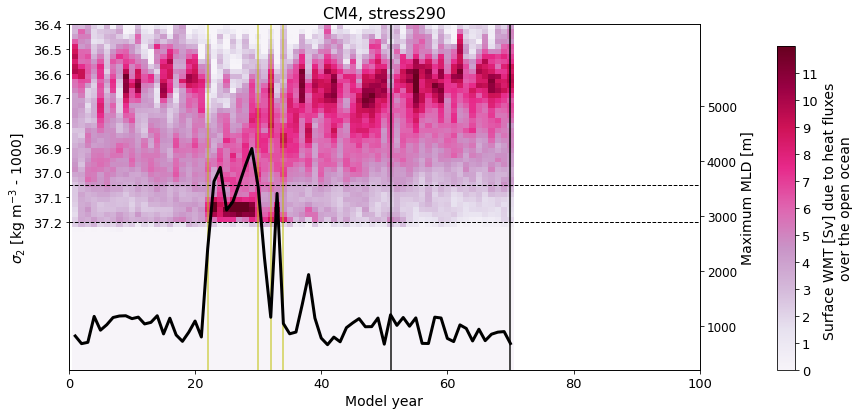

In [7]:
mod = 'CM4' # CM4, ESM4
exp = 'stress' # control, antwater, stress, antwaterstress
midx = 1
tprds = tprds_ply[mod][exp] if exp=='control' else tprds_ply[mod][exp][midx]
var = 'offshr_heat'

if exp=='control':
    xlimrange = [250,400] if mod=='CM4' else [100,270]
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
else:
    xlimrange = [0,100]
    ti,tf = 51,70

if exp=='control':
    G = tsdict[mod][exp][var].groupby('time.year').mean('time')
    mld_max = ddict_mld[mod][exp]
else:
    G = tsdict[mod][exp][var].isel(mem=midx).dropna(dim='time').groupby('time.year').mean('time')
    mld_max = ddict_mld[mod][exp].isel(mem=midx).dropna(dim='year')

fig, ax = plt.subplots(figsize=(12,6))
fig.subplots_adjust(left=0.1, right=0.83, bottom=0.1, top=0.9)

p = G.T.plot(ax=ax, yincrease=False, cmap='PuRd', vmin=0, vmax=12, add_colorbar=False, add_labels=False)

ax.axhline(y=37.05, xmin=0, xmax=1, c = 'k', lw=1.0, ls='--')
ax.axhline(y=37.20, xmin=0, xmax=1, c = 'k', lw=1.0, ls='--')

ax.axvline(x=int(ti), ls='-', lw=2, alpha=0.7, color='k',label=None)
ax.axvline(x=int(tf), ls='-', lw=2, alpha=0.7, color='k',label=None)
for j, tprd in enumerate(tprds):
    if tprd[0]:
        ax.axvline(x=int(tprd[0]), ls='-', lw=2, alpha=0.5, color='y',label=None)
        ax.axvline(x=int(tprd[1]), ls='-', lw=2, alpha=0.5, color='y',label=None)
    
ax.set_xlim(xlimrange)
ax.set_ylim([37.8,36.4])
ax.set_yticks(np.arange(36.4,37.3,0.1))
ax.tick_params(axis='both', which='major', labelsize=13)

ax.set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
ax.set_xlabel(r'Model year',fontsize=14)
ax.set_title(mod+', '+exp+'%s'%('' if exp=='control' else str(tsdict[mod][exp][var].isel(mem=midx).mem.values)), fontsize=16)

parax = ax.twinx()
mld_max.plot(ax=parax,lw=3,c='k',_labels=False)
parax.set_ylim([200,6500])
parax.set_yticks(np.arange(1000,6000,1000))
parax.set_xlim(xlimrange)
parax.tick_params(axis='both', which='major', labelsize=12)
parax.set_ylabel('Maximum MLD [m]',fontsize=14)

cax = fig.add_axes([0.92, 0.1, 0.02, 0.75])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(0,12,1), orientation='vertical', pad=0.02)
cb.set_label('Surface WMT [Sv] due to heat fluxes \nover the open ocean', fontsize=14)
cb.ax.tick_params(labelsize=13)

plt.show()

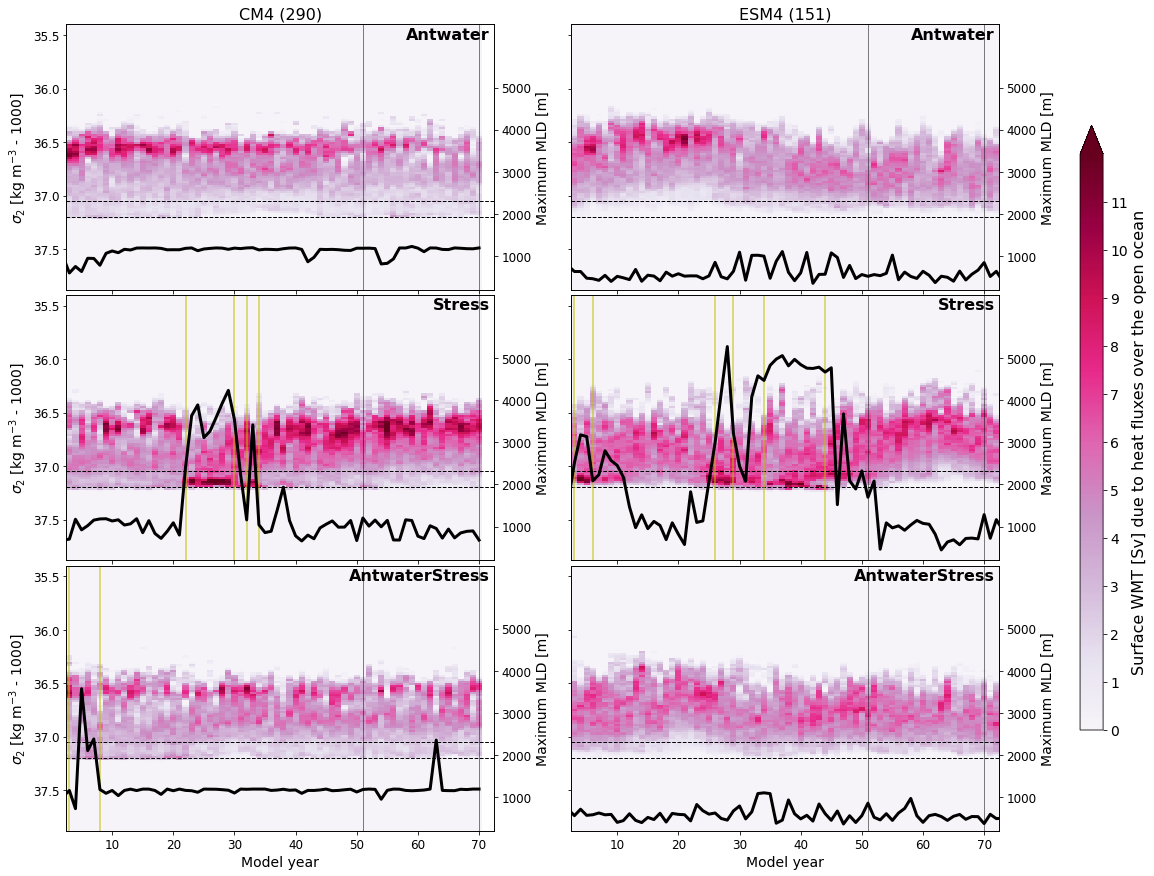

In [8]:
midx = 1
emean = False

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(left=0.05, right=0.86, bottom=0.1, top=0.9, hspace=0.02, wspace=0.18)

for i, mod in enumerate(ddict):
    
    for j, exp in enumerate(list(ddict[mod].keys())[1:]):
        
        G = tsdict[mod][exp][var].groupby('time.year').mean('time')

        if emean:
            G = tsdict[mod][exp][var].mean('mem',skipna=True)
            mld_max = ddict_mld[mod][exp].mean('mem',skipna=True)
            head = mod+'-'+exp
        else:
            G = tsdict[mod][exp][var].isel(mem=midx).dropna(dim='time')
            mld_max = ddict_mld[mod][exp].isel(mem=midx).dropna(dim='year')
            head = mod+'-'+exp+'-'+str(G.mem.values)
        

        G_ann = G.groupby('time.year').mean('time')
        p = G_ann.T.plot(ax=axs[j,i], yincrease=False, cmap='PuRd', vmin=0, vmax=12,
                         add_colorbar=False, add_labels=False)
        axs[j,i].axhline(y=37.05, xmin=0, xmax=1, c = 'k', lw=1.0, ls='--')
        axs[j,i].axhline(y=37.20, xmin=0, xmax=1, c = 'k', lw=1.0, ls='--')
        tprds = tprds_ply[mod][exp] if exp=='control' else tprds_ply[mod][exp][midx]
        for k, tprd in enumerate(tprds):
            if tprd[0]:
                axs[j,i].axvline(x=int(tprd[0]), ls='-', lw=2, alpha=0.5, color='y',label=None)
                axs[j,i].axvline(x=int(tprd[1]), ls='-', lw=2, alpha=0.5, color='y',label=None)

        
        #axs[j,i].set_ylim([37.8,34.05])
        #axs[j,i].set_yticks(np.arange(34.2,38,0.1), minor=True)
        
        axs[j,i].set_xlim([2.5, 72.5])
        axs[j,i].set_xticks(np.arange(10,80,10), minor=True)
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        axs[j,i].text(0.99, 0.99, exp[:8].capitalize()+exp[8:].capitalize() \
                      if exp=='antwaterstress' else exp.capitalize(), ha='right', va='top', fontsize=16, 
                      fontweight='bold',transform=axs[j,i].transAxes)
        axs[j,i].axvline(x=51, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=0.5)
        axs[j,i].axvline(x=70, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=0.5)
        
        if mod != 'CM4':
            axs[j,i].set_yticklabels([])
        else:
            axs[j,i].set_ylabel('$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
            
        if exp == 'antwaterstress':
            axs[j,i].set_xlabel(r'Model year',fontsize=14)
        else:
            axs[j,i].set_xticklabels([])
            
            
        parax = axs[j,i].twinx()
        mld_max.plot(ax=parax,lw=3,c='k',_labels=False)
        parax.set_ylim([200,6500])
        parax.set_yticks(np.arange(1000,6000,1000))
        parax.set_xlim([2.5, 72.5])
        parax.tick_params(axis='both', which='major', labelsize=12)
        parax.set_ylabel('Maximum MLD [m]',fontsize=14)
        
if emean:
    axs[0,0].set_title('CM4',fontsize=16)
    axs[0,1].set_title('ESM4',fontsize=16)
else:
    axs[0,0].set_title('CM4 ('+['251', '290', '332'][midx]+')',fontsize=16)
    axs[0,1].set_title('ESM4 ('+['101', '151', '201'][midx]+')',fontsize=16)

cax = fig.add_axes([0.93, 0.2, 0.02, 0.60])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(0,12,1), orientation='vertical', extend='max', shrink=0.9, pad=0.2)
cb.set_label('Surface WMT [Sv] due to heat fluxes over the open ocean', fontsize=16)
cb.ax.tick_params(labelsize=14)
plt.show()

In [9]:
md = 7
ed = 2
dd = 0.5

mticks = []
# Initialize starting value
value_start = 0
for m in range(0, 2):
    eticks = []
    for e in range(0,3):
        if m==1:
            value = value_start+md
        else:
            value = value_start
        value_next = value+md-ed if e==0 else value+md if e==1 else value+md+ed
        eticks.append(value_next)
    mticks = mticks+eticks
    
yticks = []
yticklab = []
for tick in mticks:
    dticks = []
    for d in range(0,3):
        tick_next = tick-dd if d==0 else tick if d==1 else tick+dd
        dticks.append(tick_next)
        yticklab.append(d+1)
    yticks = yticks+dticks

In [10]:
ply_type = {mod:{} for mod in ['CM4','ESM4']}
ply_type['CM4']['control'] = ['r', 'r', 'r', 'r']
ply_type['CM4']['antwater'] = [[None], [None], [None]]
ply_type['CM4']['antwaterstress'] = [[None], ['w'], ['w']]
ply_type['CM4']['stress'] = [['r','w'], ['r','r'],['r','w']]
ply_type['ESM4']['control'] = ['r', 'r', 'w', 'r', 'r', 'r', 'r', 'w', 'w', 'w']
ply_type['ESM4']['antwater']  = [[None], [None], [None]]
ply_type['ESM4']['antwaterstress'] = [[None], [None], [None]]
ply_type['ESM4']['stress'] = [['r', 'w'], ['r', 'rw', 'w', 'r'], ['r', 'w', 'rw']]

### Figure 1

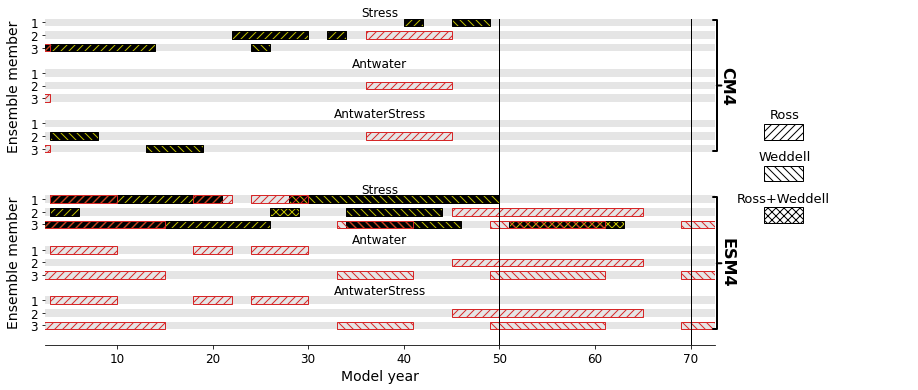

In [11]:
bwidth = 0.3

fig, ax = plt.subplots(figsize=(12,6))
#ax.axis('off')
idx = 0
for i, mod in enumerate(['CM4', 'ESM4']):
    ax.text(73, yticks[idx+4], mod, ha='left', va='center', fontsize=16, fontweight='bold', rotation=270)
    ax.annotate('', xy=(1, 0.795 if mod=='CM4' else 0.25), xytext=(1.02, 0.795 if mod=='CM4' else 0.25),
            fontsize=14, ha='center', va='center', xycoords='axes fraction', 
            bbox=dict(boxstyle='round', facecolor='w', alpha=0.5),
            arrowprops=dict(arrowstyle='-[, widthB=4.7, lengthB=.3', lw=2.0))
    ax.text(0, yticks[idx+4], 'Ensemble member', ha='right', va='center', fontsize=14, rotation=90)
    
    for j, exp in enumerate(['stress', 'antwater', 'antwaterstress']):
        for m, tprds in enumerate(tprds_ply[mod][exp]):
            #print(mod,exp,m+1,tprds,yticks[idx])
            if m==0:
                ax.text(37.5, yticks[idx]-dd/4, exp[:8].capitalize()+exp[8:].capitalize() \
                      if exp=='antwaterstress' else exp.capitalize(), ha='center', va='bottom', fontsize=12)
                
            ax.bar(0, bwidth, 100, yticks[idx]-bwidth/2, color='k', alpha=0.1, align='edge',
                           label='%s-%s-%s'%(mod,exp,str(m+1)))
            for k, tprd in enumerate(tprds):
                #print(ply_type[mod][exp][m][k])
                if tprd[0] is None:
                    continue
                ax.bar(int(tprd[0]), bwidth, int(tprd[1])-int(tprd[0]), yticks[idx]-bwidth/2, color='k', align='edge',
                       label='%s-%s-%s'%(mod,exp,str(m+1)))
                ax.bar(int(tprd[0]), bwidth, int(tprd[1])-int(tprd[0]), yticks[idx]-bwidth/2, 
                       color='none', align='edge', edgecolor='y', zorder=1, lw=1,
                       hatch='///' if ply_type[mod][exp][m][k]=='r' else '\\\\\\' if ply_type[mod][exp][m][k]=='w' else 'XXX')
                ax.bar(int(tprd[0]), bwidth, int(tprd[1])-int(tprd[0]), yticks[idx]-bwidth/2, color='none', align='edge',
                       edgecolor='k', zorder=2, lw=1)
                
            for kc, tprdc in enumerate(tprds_ply[mod]['control']):
                ctr_pi = int(tprdc[0])-tsdict[mod][exp].mem.values[m]
                ctr_pf = int(tprdc[1])-tsdict[mod][exp].mem.values[m]
                ax.bar(ctr_pi, bwidth, ctr_pf-ctr_pi, yticks[idx]-bwidth/2, 
                       color='none', align='edge', edgecolor='tab:red', zorder=2, lw=1,
                       hatch='///' if ply_type[mod]['control'][kc]=='r' \
                       else '\\\\\\' if ply_type[mod]['control'][kc]=='w' else 'XXX')
            idx += 1
                
ax.axvline(x=50, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-')
ax.axvline(x=70, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-')
ax.invert_yaxis()
# Hide the right and top spines
ax.spines[['right', 'top','left']].set_visible(False)
# Add y-tick labels
ax.set_yticks(yticks)
ax.set_yticklabels(yticklab)
ax.set_xlim([2.5, 72.5])
ax.set_xticks(np.arange(10,80,10), minor=True)
ax.set_xlabel(r'Model year',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ylimit = ax.get_ylim()
ax.set_ylim(ylimit)

p1=ax.bar(-1, -1, bwidth, align='center', fill=False, edgecolor='k', hatch='///',label='Ross')
p2=ax.bar(-1, -1, bwidth, align='center', fill=False, edgecolor='k', hatch='\\\\\\',label='Weddell')
p3=ax.bar(-1, -1, bwidth, align='center', fill=False, edgecolor='k', hatch='XXX',label='Ross+Weddell')
leg = ax.legend(handles=[p1,p2,p3],frameon=False, fancybox=False, bbox_to_anchor=(1.18, 0.525), loc='center',
                ncol=1, fontsize=13,labelspacing=2, handlelength=3, handleheight=1.5)

for t, txt in enumerate(leg.get_texts()):
    txt.set_ha('center')
    txt.set_x(-44 if t==0 else -55 if t==1 else -77)
    txt.set_y(+18)

#ax.margins(x=10)
#fig.tight_layout()
#fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
#fig.patch.set_linewidth(10)
#fig.patch.set_edgecolor('cornflowerblue')

plt.savefig('polynyas_timeline.png', dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', format='pdf', transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

**Figure 1**: Timing and duration of open-ocean polynyas for each 70-year simulation run of the three perturbations (Stress, Antwater, and AntwaterStress) for CM4 and ESM4 models. There are 18 timelines along the horizontal axis, each represented as a grey band with an x-axis as the Model year going from 0 to 70 years. The presence of open-ocean polynya(s) is highlighted as black bars along a given timeline with the overlaying hatch pattern denoting whether the polynya occurs in the Ross Sea (diagonal right), Weddell Sea (diagonal left) or in both regions (diagonal left and right). The red bars overlaid on top indicate the timing and duration of the polynyas during the corresponding 70-year period in the Control. The presence of a polynya was determined based on whether the annual maximum mixed layer depth in the open subpolar Southern Ocean (south of 60$^\circ$S) exceeds 2000 m.